# T-matrix computation for 3D acoustic scattering 

In [2]:
import bempp.api
import numpy as np
import scipy
from numba import objmode
import numba
import math
import cmath
%matplotlib inline
import matplotlib.pyplot as plt
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
bempp.api.show_available_platforms_and_devices()
bempp.api.set_default_device(0, 0)

0: Portable Computing Language
    0: pthread-Intel(R) Xeon(R) W-2155 CPU @ 3.30GHz


In [9]:
def normalized_spherical_harmonics(p, q, x):
    """Spherical Harmonic function of degree q"""
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/np.linalg.norm(x))
    if p >= 0:
        return ((-1)**p) * scipy.special.sph_harm(p,q,azimuth,polar)
    else:
        return scipy.special.sph_harm(-p,q,azimuth,polar)*np.exp(1j*2*p*azimuth)

def spherical_bessel_function(q,x,k):
    """Spherical Bessel function of degree q"""
    r = np.linalg.norm(x)
    return np.sqrt(np.pi/(2*k*r))*scipy.special.jv(q+0.5, k*r)

def regular_spherical_wavefunctions(p,q,x,k):
    """Regular Spherical Wavefunction"""
    return spherical_bessel_function(q,x,k)*normalized_spherical_harmonics(p,q,x)

In [4]:
d = [1,0,0] # wave's travel direction
deg = 10

In [20]:
h = 0.2
# far field points: unit sphere
unit_sphere = bempp.api.shapes.sphere(r = 1, origin=(0,0,0), h = h)
vert_sphere = unit_sphere.vertices
space_sphere = bempp.api.function_space(unit_sphere, 'P', 1)

# scatterer: sphere
dom_cube = bempp.api.shapes.cube(length = 2/1.8, origin=(-1/1.8,-1/1.8,-1/1.8), h = h)
vert_cube = dom_cube.vertices
space_cube = bempp.api.function_space(dom_cube,'P',1)

In [33]:
def KSSF(k):
    eta = k

    identity = bempp.api.operators.boundary.sparse.identity(space_cube, space_cube,space_cube)
    slp = bempp.api.operators.boundary.helmholtz.single_layer(space_cube,space_cube,space_cube,k)
    dlp = bempp.api.operators.boundary.helmholtz.double_layer(space_cube,space_cube,space_cube,k)
    slp_far = helmholtz_farfield.single_layer(space_cube, vert_sphere, k)
    dlp_far = helmholtz_farfield.double_layer(space_cube, vert_sphere,k)

    lhs = 0.5 * identity + dlp - 1j* eta *slp

    slp_far_field_coeff = []
    sph_harm_coeff = []

    for q in range(deg+1):
        for p in range(-q,q+1):
            @bempp.api.complex_callable
            def dirichlet_fun(x,n,domain_index,result):
                    with objmode():
                        result[0] = - regular_spherical_wavefunctions(p,q,x,k)

            rhs_fun = bempp.api.GridFunction(space_cube, fun = dirichlet_fun)
            field, info = bempp.api.linalg.gmres(lhs, rhs_fun, tol=1E-8)
            slp_far_field_coeff.append(dlp_far.evaluate(field) - 1j * eta * slp_far.evaluate(field))

            @bempp.api.complex_callable
            def sph_harm(x,n,domain_index,result):
                with objmode():
                    result[0] = normalized_spherical_harmonics(p,q,x)
            sph_harm_grid = bempp.api.GridFunction(space_sphere,fun = sph_harm)
            sph_harm_coeff.append(np.conj(sph_harm_grid.coefficients)/((-1j)**(q+1)))

    mass_mat = bempp.api.operators.boundary.sparse.identity(space_sphere,space_sphere,space_sphere).weak_form().A
    T_matrix = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
    for i in range((deg+1)**2):
        for j in range((deg+1)**2):
            T_matrix[i,j] = (slp_far_field_coeff[j] @ mass_mat @ sph_harm_coeff[i])*k
    P,L,U = scipy.linalg.lu(np.identity(T_matrix.shape[0]) + T_matrix)
    logdet = 0
    for i in range (T_matrix.shape[0]):
        logdet += cmath.log(U[i,i])
        
    return logdet/(2*np.pi*1j)

In [34]:
KSSF(5)

(-1.5372302643453142+1.6429011071510724j)

In [38]:
list_KSSF = []
for k in [3,5,7,9,11]:
    list_KSSF.append(KSSF(k))

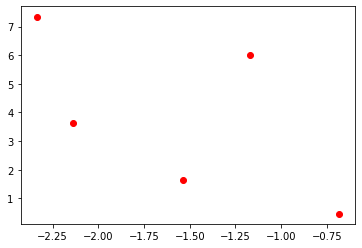

In [41]:
X = [x.real for x in list_KSSF]
Y = [x.imag for x in list_KSSF]
plt.scatter(X,Y, color='red')
plt.show()

In [40]:
list_KSSF

[(-0.686244502223044+0.46753590625624475j),
 (-1.5372302643453142+1.6429011071510724j),
 (-2.1409367635476984+3.624815472221511j),
 (-1.172289094354187+5.9917347981438525j),
 (-2.3338702715599564+7.348068559836775j)]

In [51]:
list_KSSF2 = [list_KSSF[0]*(2*np.pi*1j),list_KSSF[1]*(2*np.pi*1j),list_KSSF[2]*(2*np.pi*1j),list_KSSF[3]*(2*np.pi*1j),list_KSSF[4]*(2*np.pi*1j)]

In [52]:
list_KSSF2

[(-2.9376147367681296-4.311801373500599j),
 (-10.322652097600693-9.65870261068627j),
 (-22.775387316299433-13.451902416323515j),
 (-37.647180048214096-7.365709613413092j),
 (-46.169276411314684-14.664139399128748j)]

In [56]:
list_KSSF2[0] = (list_KSSF2[0] + 2*np.pi*1j)/(2*np.pi*1j)
list_KSSF2[1] = (list_KSSF2[1] + 4*np.pi*1j)/(2*np.pi*1j)
list_KSSF2[2] = (list_KSSF2[2] + 5*np.pi*1j)/(2*np.pi*1j)
list_KSSF2[3] = (list_KSSF2[3] + 3*np.pi*1j)/(2*np.pi*1j)
list_KSSF2[4] = (list_KSSF2[4] + 5*np.pi*1j)/(2*np.pi*1j) 

In [57]:
list_KSSF2

[(1.3137554977769559+0.46753590625624475j),
 (2.462769735654686+1.6429011071510724j),
 (2.8590632364523016+3.624815472221511j),
 (1.827710905645813+5.9917347981438525j),
 (2.6661297284400436+7.348068559836775j)]

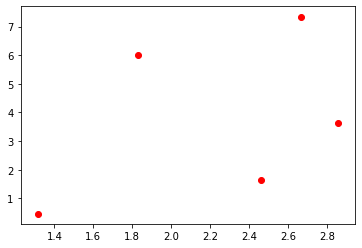

In [58]:
X2 = [x.real for x in list_KSSF2]
Y2 = [x.imag for x in list_KSSF2]
plt.scatter(X2,Y2, color='red')
plt.show()